In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

In [60]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
## taking data

df = pd.read_excel('/content/drive/MyDrive/Online Retail.xlsx')

In [ ]:
df.head()

In [ ]:
## so 8 features are there and as unsuperviser, so no label, just these 8 features and we need to compute clusters, based on the transaction

## Gist and Target 
### we can multiply the quantity to unit price, and we have the transaction amount
### Then we can check for each unique customer's value to the company, by adding their total order amount and also frequency(let's say)
### Also, we can see the recency, basically the last order of a  particular customer

# Lets first check some common EDA

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [63]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Text(0.5, 1.0, 'Ratio of missing values per columns')

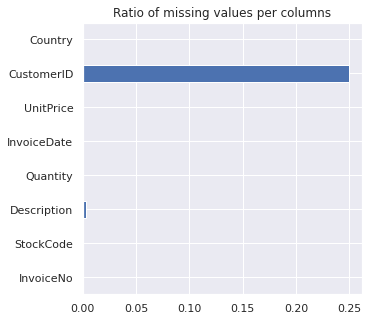

In [64]:
#plot of NaN values in dataset
plt.figure(figsize=(5, 5))
df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [65]:
## so we have a lot of null values in customerID, these are the main thing, bcz we can not fill these values with any of the number
## as these are customers only, so we have to remove them

In [66]:
df_nn = df.dropna(axis = 0)

In [67]:
df_nn.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [68]:
df_nn.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [69]:
df_nn[df_nn['Quantity'] <0 ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [70]:
## so we can see, qty< 0  means, they must have returned or cancel the order, also it is confirmed from the C in the starting of 
## Invoice No. , so we can remove these rows

In [71]:
df_nn = df_nn[~df_nn['Quantity'] <0] # command for removing, or ignoring these values

In [72]:
df_nn.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [73]:
## so now this is clean dataset with around 4 Lakh entries
## but max qty seems to be the outlier, we will check it later on

In [74]:
## lets convert the invoice column into different col having date year and month

#fetching year from InvoiceDate and storing in column 'Year'
df_nn['Year']=df_nn['InvoiceDate'].dt.year

#fetching month from InvoiceDate and storing in column 'Month'
df_nn['Month']=df_nn['InvoiceDate'].dt.month

#fetching Day from InvoiceDate and storing in column 'Day'
df_nn['Day']=df_nn['InvoiceDate'].dt.day

#fetching time from InvoiceDate and storing in column 'Time'
df_nn['Hour']=df_nn['InvoiceDate'].dt.hour

# fetching time from InvoiceDate and storing in column 'Time'
df_nn['Minute']=df_nn['InvoiceDate'].dt.minute

In [75]:
df_nn.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Hour,Minute
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,8,26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,8,26
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26


In [76]:
## now this looks good, we can consider removing duplicate entries
## then we will look for transaction's frequency month, year, day and time wise

In [77]:
# Duplicates
len(df_nn[df_nn.duplicated()])

5192

In [78]:
#dropping them
df_nn.drop_duplicates(inplace = True)

In [79]:
import seaborn as sns
sns.set()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Yearly transactions count')

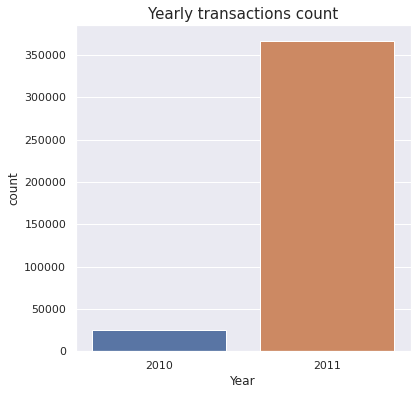

In [80]:
plt.figure(figsize = (6,6))
sns.countplot(df_nn.Year)
plt.title('Yearly transactions count',fontsize=15)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Monthly transactions count')

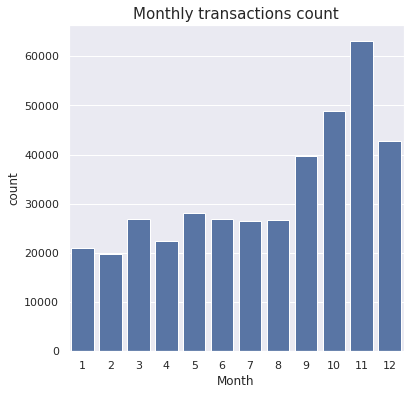

In [81]:
plt.figure(figsize = (6,6))
sns.countplot(df_nn.Month, color='b')
plt.title('Monthly transactions count',fontsize=15)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Daily transactions count')

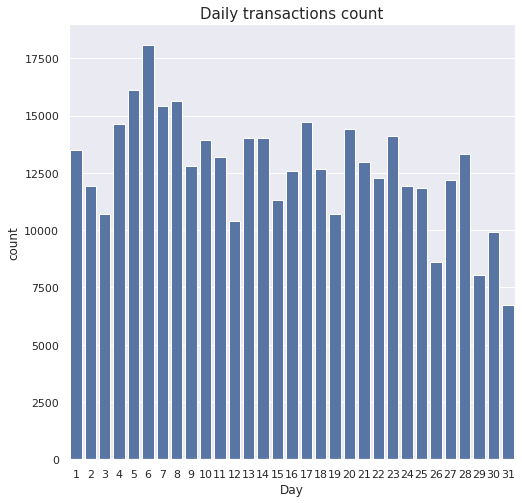

In [82]:
plt.figure(figsize = (8,8))
sns.countplot(df_nn.Day, color='b')
plt.title('Daily transactions count',fontsize=15)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Hourly transactions count')

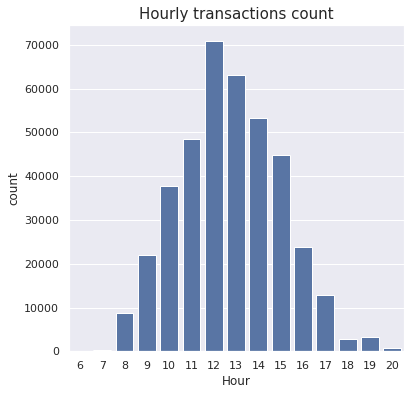

In [83]:
plt.figure(figsize = (6,6))
sns.countplot(df_nn.Hour, color='b')
plt.title('Hourly transactions count',fontsize=15)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Countries')

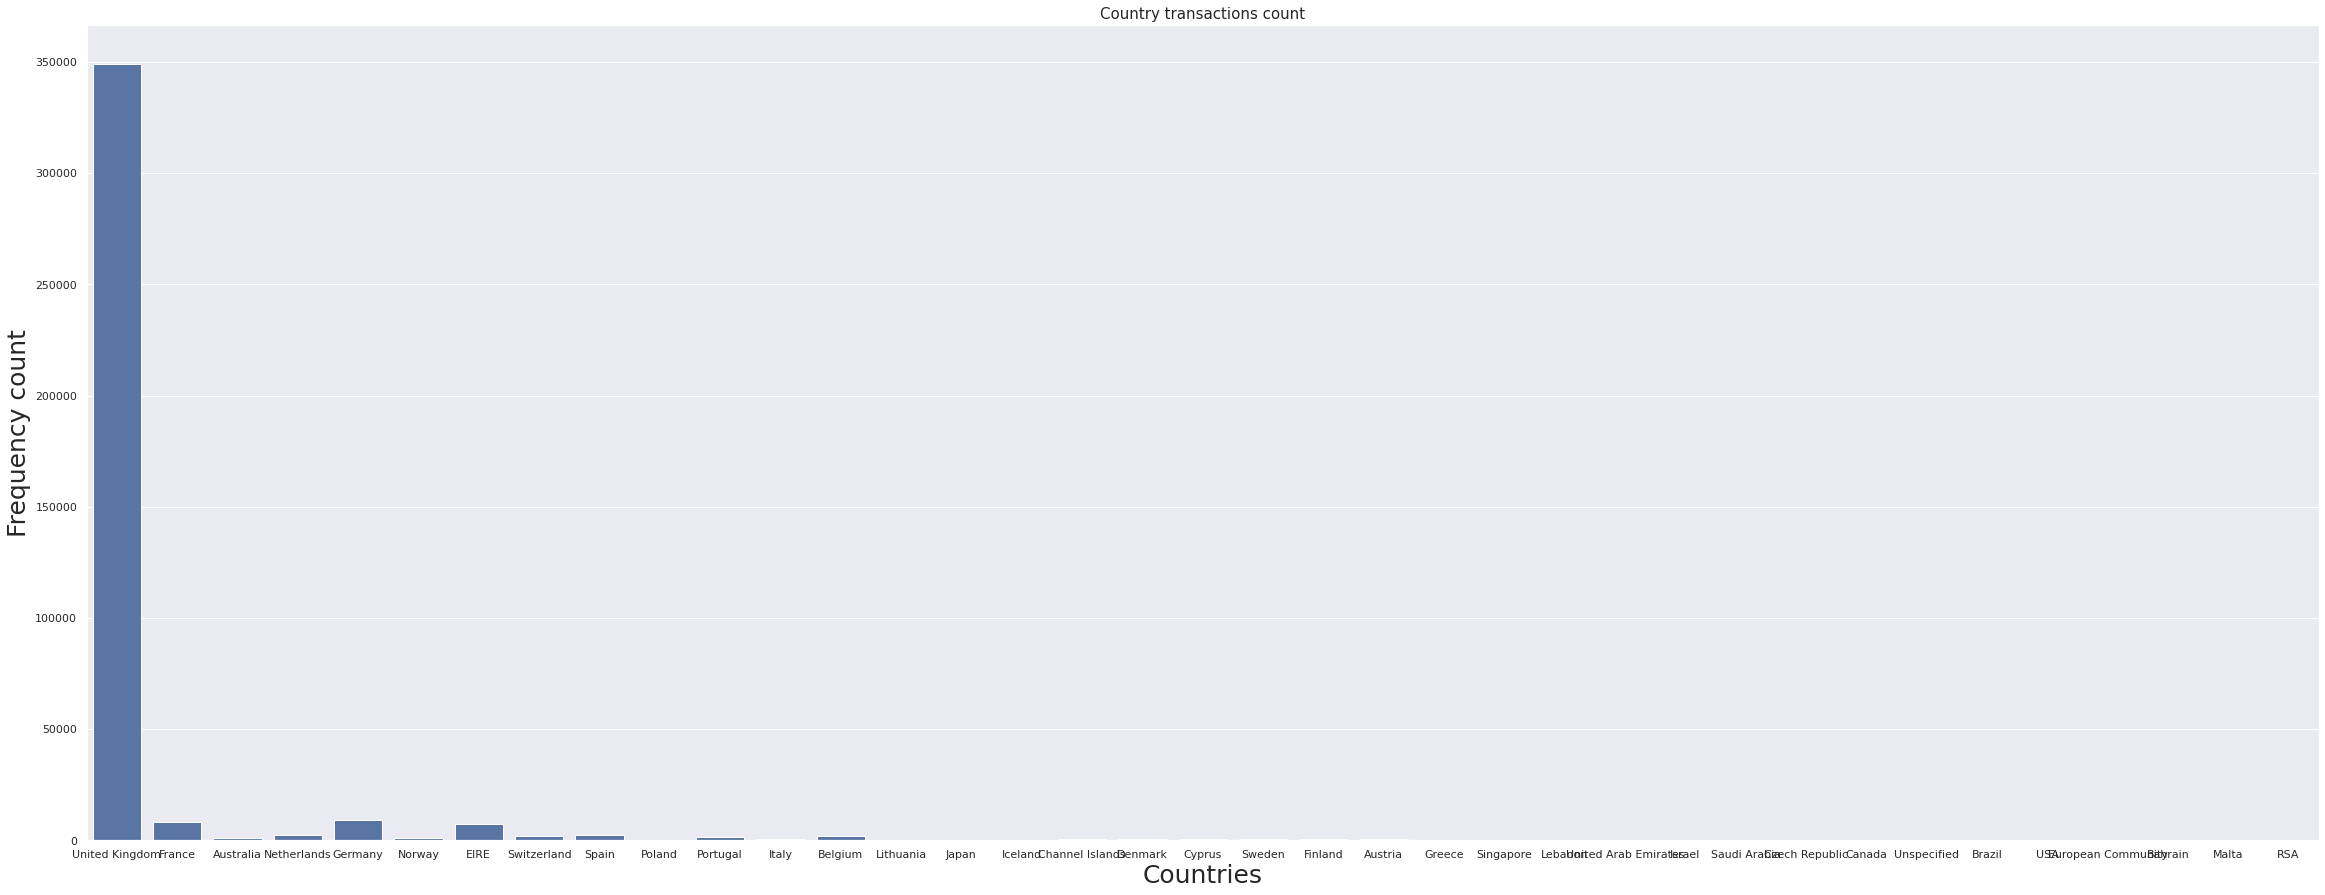

In [84]:
plt.figure(figsize = (40,15))
sns.countplot(df_nn.Country, color='b')
plt.title('Country transactions count',fontsize=15)
plt.ylabel('Frequency count',fontsize=25)
plt.xlabel('Countries',fontsize=25)

Text(0.5, 0, 'products')

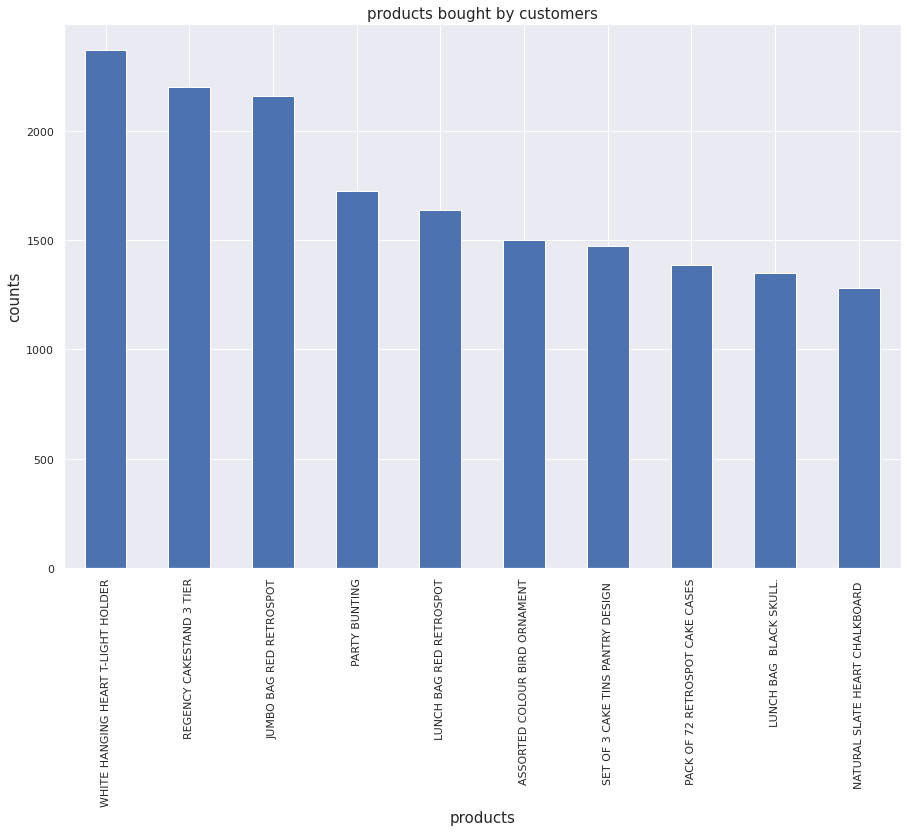

In [85]:
#Top products purchased by the customers
df['Description'].value_counts().head(10).plot(kind='bar',figsize=(15,10))
plt.title('products bought by customers',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.xlabel('products',fontsize=15)

## now we can check the transaction amount in each of these features

## Transaction = Qty X price

In [86]:
df_nn['Trans_amt'] = df_nn['Quantity'] * df_nn['UnitPrice']

In [87]:
# Aggregation plot of Month, Day, and Year with respect to Trans_amt
Month_sales = pd.DataFrame(df_nn.groupby('Month').agg({'Trans_amt':'mean'}))
Day_sales = pd.DataFrame(df_nn.groupby('Day').agg({'Trans_amt':'mean'}))
Year_sales = pd.DataFrame(df_nn.groupby('Year').agg({'Trans_amt':'mean'}))


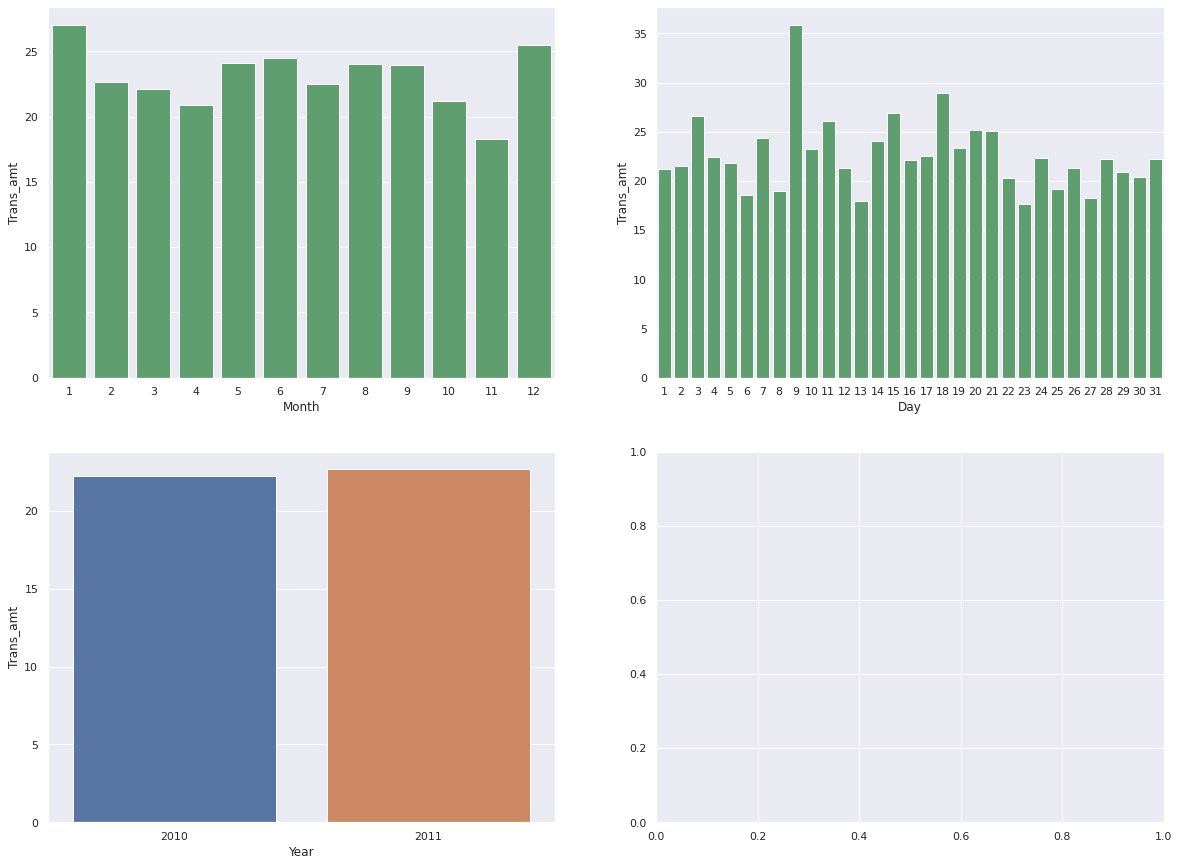

In [88]:
fig, ax = plt.subplots(2,2,figsize=(20,15))   
ax1=plt.subplot(2,2 ,1)
import seaborn as sns
sns.barplot(x=Month_sales.index, y = Month_sales['Trans_amt'],color='g')
ax1=plt.subplot(2, 2,2)
sns.barplot(x=Day_sales.index, y = Day_sales['Trans_amt'],color='g')
ax1=plt.subplot(2, 2,3)
sns.barplot(x=Year_sales.index, y = Year_sales['Trans_amt'])

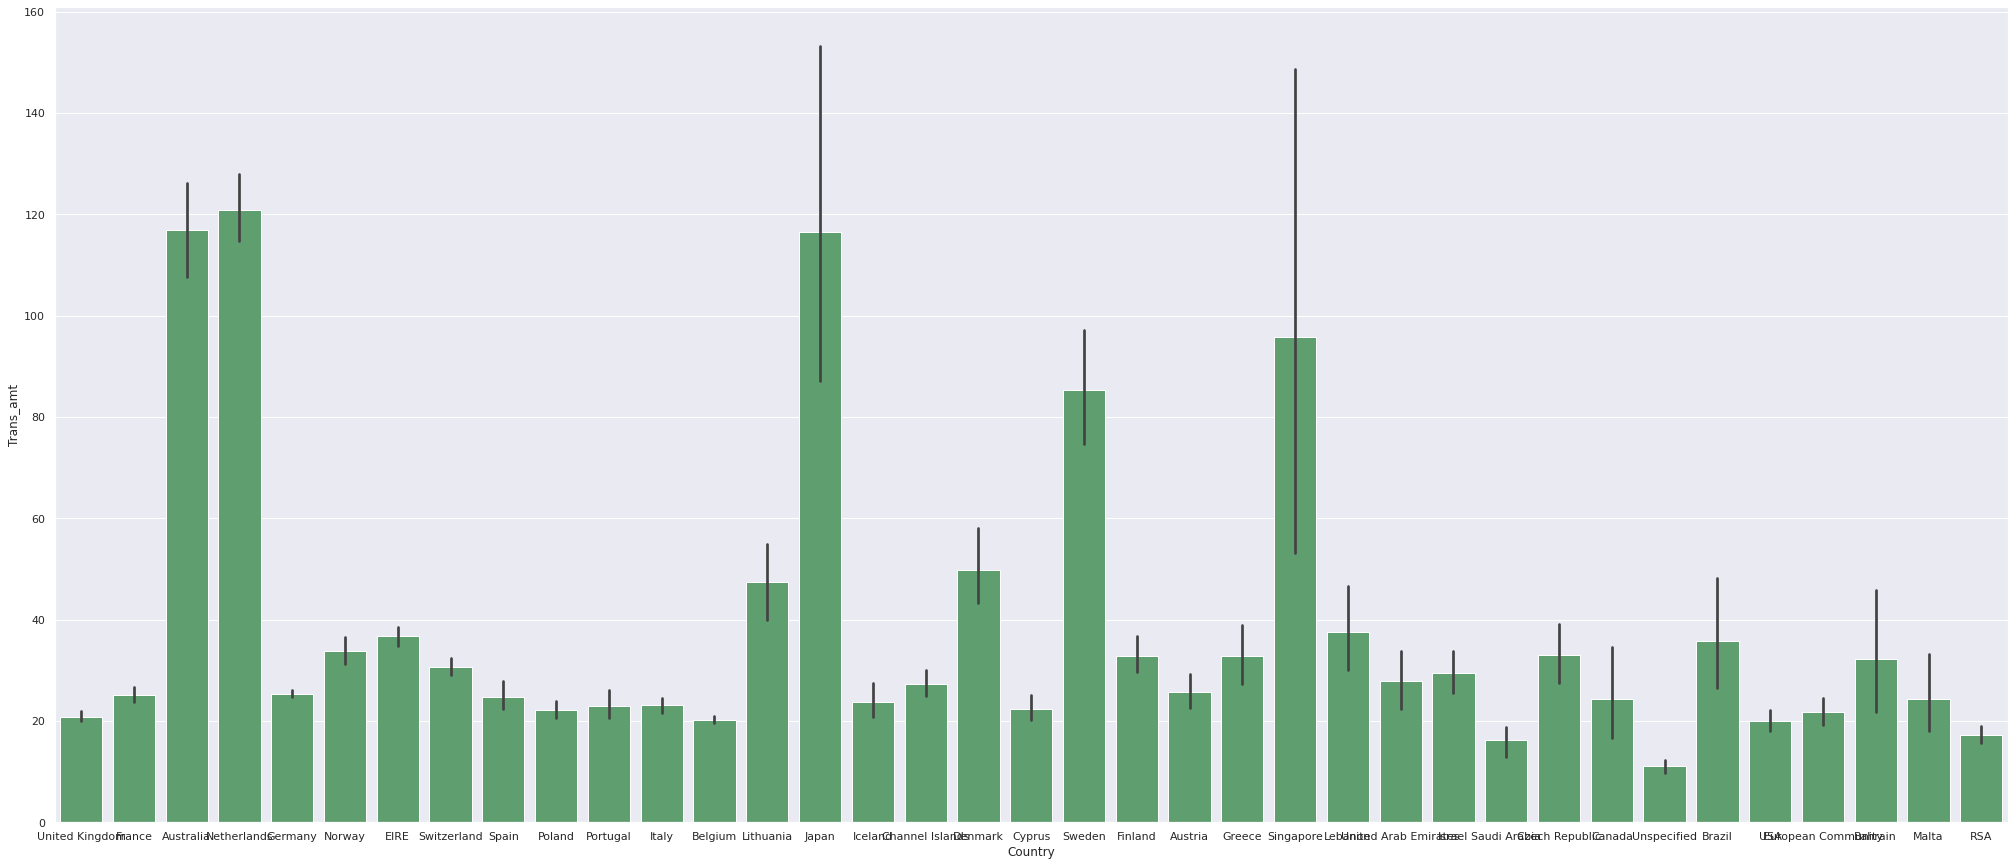

In [89]:
## lets check country wise


plt.subplots(figsize=(35,15))   
sns.barplot(x=df_nn['Country'], y = df_nn['Trans_amt'],color='g')

## Target 
### we can multiply the quantity to unit price, and we have the transaction amount
### Then we can check for each unique customer's value to the company, by adding their total order amount and also frequency(let's say)
### Also, we can see the recency, basically the last order of a  particular customer

In [ ]:
## lets check total amt of transaction of customer

total_trans = df_nn.groupby('CustomerID')['Trans_amt'].sum()
total_trans = total_trans.reset_index()
total_trans.columns = ['CustomerID', 'Total_Trans_amt']
total_trans.head()

In [ ]:
## now we will add two more columns, that is the last purchase(recency) and frequency

In [ ]:
## frequency

total_freq = df_nn.groupby('CustomerID')['InvoiceNo'].count()
total_freq = total_freq.reset_index()
total_freq.columns = ['CustomerID','Frequency']

In [90]:
total_freq.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [91]:
## great, now we can merge these two DF and add the last feature which is recency 

In [92]:
total_f_t = pd.merge(total_freq, total_trans, on = 'CustomerID')

In [93]:
total_f_t.head()

,CustomerID,Frequency,Total_Trans_amt
0,12346.0,1,77183.60
1,12347.0,182,4310.00
2,12348.0,31,1797.24
3,12349.0,73,1757.55
4,12350.0,17,334.40


In [94]:
## adding the last one

In [95]:
## we can do one thing here, we can search for the difference of last transaction's date and the date of purchase
## then from that, we can find the minimum difference, i.e the last current date of purchasing

In [96]:
df_nn['InvoiceDate'] = pd.to_datetime(df_nn['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [97]:
df_nn['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [98]:
df_nn['Difference'] = df_nn['InvoiceDate'].max() - df_nn['InvoiceDate']
df_nn.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Hour,Minute,Trans_amt,Difference
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,8,26,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,8,26,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,20.34,373 days 04:24:00


In [99]:
df_nn.groupby('CustomerID')['Difference'].min()

CustomerID
12346.0   325 days 02:49:00
12347.0     1 days 20:58:00
12348.0    74 days 23:37:00
12349.0    18 days 02:59:00
12350.0   309 days 20:49:00
                 ...       
18280.0   277 days 02:58:00
18281.0   180 days 01:57:00
18282.0     7 days 01:07:00
18283.0     3 days 00:48:00
18287.0    42 days 03:21:00
Name: Difference, Length: 4339, dtype: timedelta64[ns]

In [100]:
## so this is the thing, which we need to enter into our final dataset total_f_t

In [101]:
df_recency = df_nn.groupby('CustomerID')['Difference'].min()
df_recency = df_recency.reset_index()
df_recency.columns = ['CustomerID', 'last_purchase']
df_recency.head()

,CustomerID,last_purchase
0,12346.0,325 days 02:49:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [102]:
df_final = pd.merge(total_f_t, df_recency, on = 'CustomerID')

In [103]:
df_final.head()

,CustomerID,Frequency,Total_Trans_amt,last_purchase
0,12346.0,1,77183.60,325 days 02:49:00
1,12347.0,182,4310.00,1 days 20:58:00
2,12348.0,31,1797.24,74 days 23:37:00
3,12349.0,73,1757.55,18 days 02:59:00
4,12350.0,17,334.40,309 days 20:49:00


In [104]:
df_final['last_purchase'] = df_final['last_purchase'].dt.days

# Model Preparation 

In [105]:
## I will do clustering with KNN and will use some methods to check the optimum number of clusters

In [106]:
## lets check the outliers first and delete/remove them and normalise our inputs

In [107]:
df_final.columns[1:]

Index(['Frequency', 'Total_Trans_amt', 'last_purchase'], dtype='object')

Text(0.5, 0, 'Attributes')

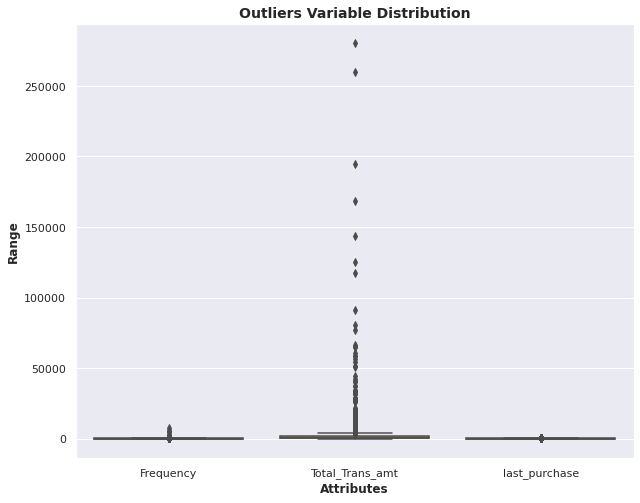

In [108]:
attributes = ['Frequency', 'Total_Trans_amt', 'last_purchase']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_final[attributes])
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
## we can see there are outliers in trans_amt, we can remove some of them by quantile method

In [111]:
# Removing (statistical) outliers for Amount
Q1 = df_final['Total_Trans_amt'].quantile(0.05)
Q3 = df_final['Total_Trans_amt'].quantile(0.95)
IQR = Q3 - Q1
df_final = df_final[(df_final['Total_Trans_amt'] >= Q1 - 1.5*IQR) & (df_final['Total_Trans_amt'] <= Q3 + 1.5*IQR)]

Q1 = df_final['Frequency'].quantile(0.05)
Q3 = df_final['Frequency'].quantile(0.95)
IQR = Q3 - Q1
df_final = df_final[(df_final['Frequency'] >= Q1 - 1.5*IQR) & (df_final['Frequency'] <= Q3 + 1.5*IQR)]


Q1 = df_final['last_purchase'].quantile(0.05)
Q3 = df_final['last_purchase'].quantile(0.95)
IQR = Q3 - Q1
df_final = df_final[(df_final['last_purchase'] >= Q1 - 1.5*IQR) & (df_final['last_purchase'] <= Q3 + 1.5*IQR)]



Text(0.5, 0, 'Attributes')

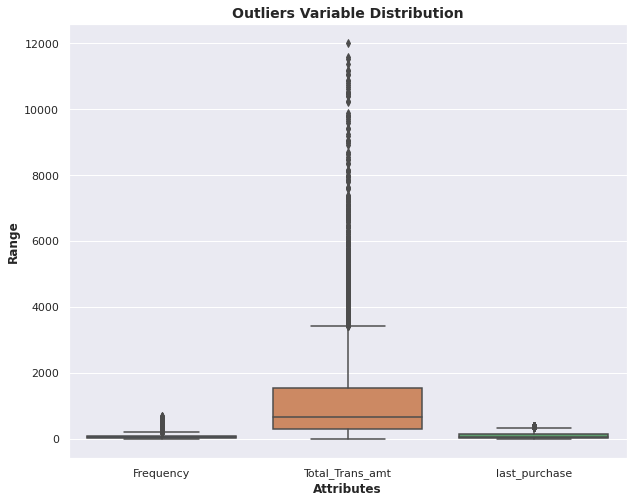

In [112]:
attributes = ['Frequency', 'Total_Trans_amt', 'last_purchase']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_final[attributes])
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

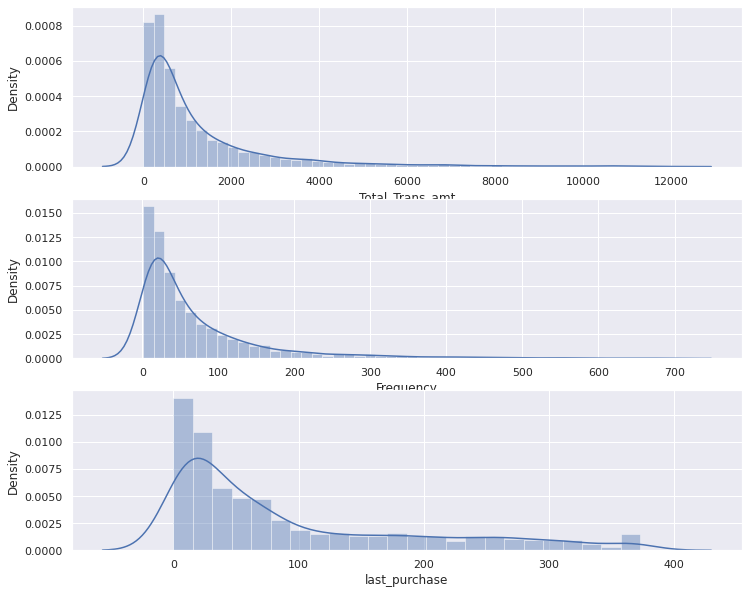

In [113]:
# Checking the distribution the variables

plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1); 
sns.distplot(df_final['Total_Trans_amt'])

plt.subplot(3, 1, 2); 
sns.distplot(df_final['Frequency'])

plt.subplot(3, 1, 3); 
sns.distplot(df_final['last_purchase'])

In [114]:
## all the three are right skewed we can see
## lets correct them with sqrt 

In [115]:
import math
from math import log1p, sqrt 
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [116]:
df_final['last_purchase_sqrt'] = df_final['last_purchase'].apply(math.sqrt) 
df_final['Frequency_sqrt'] = df_final['Frequency'].apply(math.sqrt)
df_final['Total_Trans_amt_sqrt'] = df_final['Total_Trans_amt'].apply(math.sqrt)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

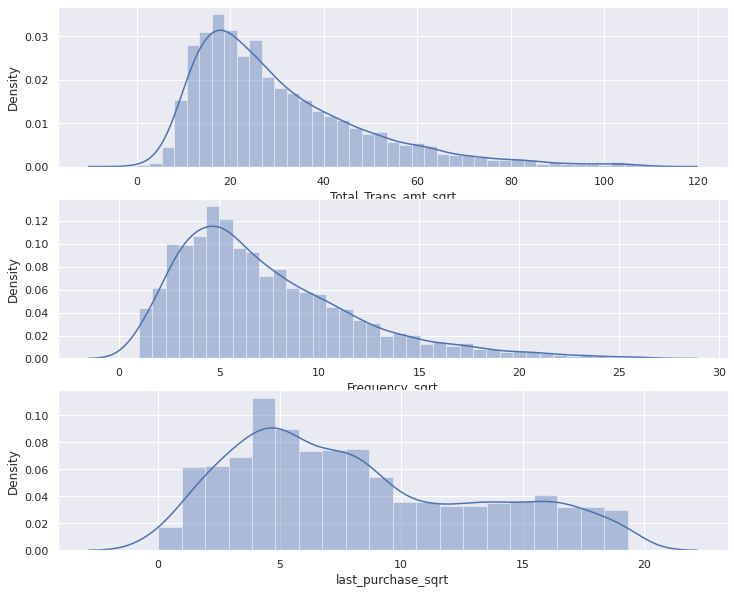

In [117]:
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1); 
sns.distplot(df_final['Total_Trans_amt_sqrt'])

plt.subplot(3, 1, 2); 
sns.distplot(df_final['Frequency_sqrt'])

plt.subplot(3, 1, 3); 
sns.distplot(df_final['last_purchase_sqrt'])

In [118]:
## its quite good as compared to previous one

In [119]:
## scaling and making model

In [132]:
final_df_scaled_parms = df_final[['last_purchase_sqrt',	'Frequency_sqrt',	'Total_Trans_amt_sqrt']]
scale = StandardScaler()
df_final_scaled = scale.fit_transform(final_df_scaled_parms)


In [133]:
df_final_scaled

array([[-1.42607197,  1.37025575,  1.91761951],
       [ 0.07426963, -0.39868287,  0.64886602],
       [-0.78612714,  0.26581323,  0.62318604],
       ...,
       [ 1.02434322, -1.05107202, -1.17345784],
       [-1.10127803, -0.86836139, -0.93595347],
       [-0.34443142,  0.22620488,  0.67448671]])

In [134]:
df_final_scaled = pd.DataFrame(df_final_scaled)
df_final_scaled.columns = ['Total_Trans_amt_sqrt', 'Frequency_sqrt', 'last_purchase_sqrt']
df_final_scaled.head()

,Total_Trans_amt_sqrt,Frequency_sqrt,last_purchase_sqrt
0,-1.426072,1.370256,1.917620
1,0.074270,-0.398683,0.648866
2,-0.786127,0.265813,0.623186
3,1.845724,-0.721228,-0.666288
4,-0.455869,0.416639,1.067106


# Model

In [150]:
## just guessing and checking by K = 4

In [135]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(df_final_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [136]:
## checking labels
kmeans.labels_

array([0, 2, 2, ..., 3, 1, 2], dtype=int32)

In [137]:
df_final_scaled['ClusterNo'] = kmeans.labels_
df_final_scaled.head()

,Total_Trans_amt_sqrt,Frequency_sqrt,last_purchase_sqrt,ClusterNo
0,-1.426072,1.370256,1.917620,0
1,0.074270,-0.398683,0.648866,2
2,-0.786127,0.265813,0.623186,2
3,1.845724,-0.721228,-0.666288,3
4,-0.455869,0.416639,1.067106,2


In [139]:
df_final_scaled.index

RangeIndex(start=0, stop=4238, step=1)

In [143]:
np.array(df_final_scaled)[:, 0]

array([-1.42607197,  0.07426963, -0.78612714, ...,  1.02434322,
       -1.10127803, -0.34443142])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


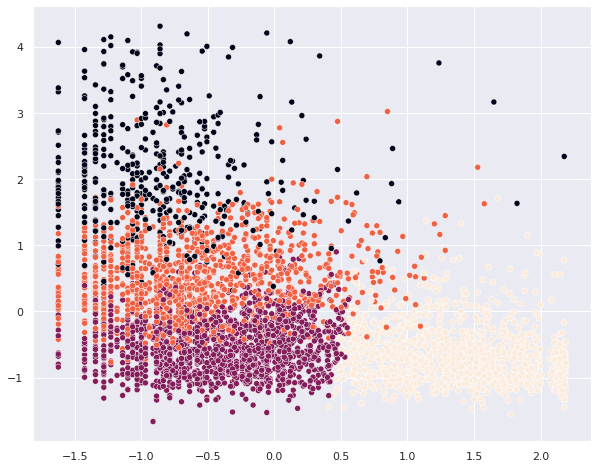

In [145]:
sns.scatterplot(np.array(df_final_scaled)[:, 0],np.array(df_final_scaled)[:, 2], c= kmeans.labels_)

In [155]:
df_final_scaled.iloc[:,:3].head()

,Total_Trans_amt_sqrt,Frequency_sqrt,last_purchase_sqrt
0,-1.426072,1.370256,1.917620
1,0.074270,-0.398683,0.648866
2,-0.786127,0.265813,0.623186
3,1.845724,-0.721228,-0.666288
4,-0.455869,0.416639,1.067106


## Finding Optimum no. of clusters

* Elbow Method
* silhouette Score 


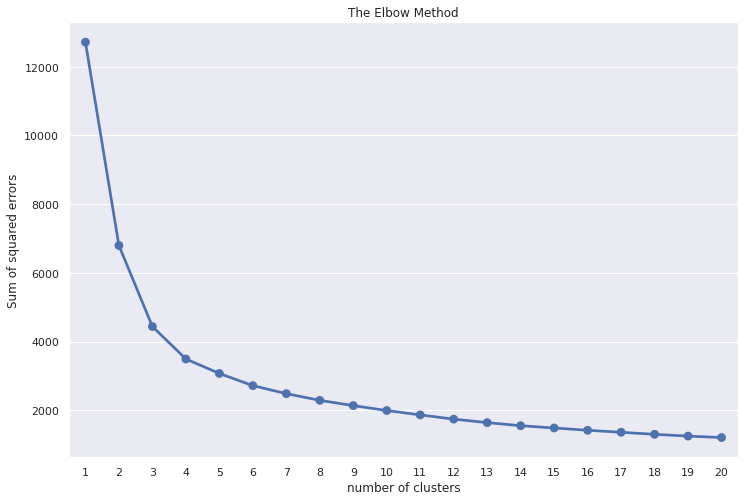

In [156]:
# Elbow-curve/SSD
wcss = {}
# Fit KMeans and calculate SSE for each k
for k in range(1,21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(df_final_scaled.iloc[:,:3])
    
    # Assign sum of squared distances to k element of dictionary
    wcss[k] = kmeans.inertia_
# Plotting the elbow plot
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('number of clusters'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.show()

In [147]:
## we can say, between 3-8 no. of clusters would be suitable
## lets check the score for these points only

In [157]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [3,4,5,6,7,8]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_final_scaled.iloc[:,:3])
    centers = clusterer.cluster_centers_

    score = silhouette_score(df_final_scaled.iloc[:,:3], preds)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 3, silhouette score is 0.3901851051400997
For n_clusters = 4, silhouette score is 0.36008578655260715
For n_clusters = 5, silhouette score is 0.345233582260781
For n_clusters = 6, silhouette score is 0.32333778722785445
For n_clusters = 7, silhouette score is 0.30955277320067265
For n_clusters = 8, silhouette score is 0.2889574872277081


In [158]:
## so we can see, 3 is the highest score
## so we will go with 3 no.

In [159]:
del df_final_scaled['ClusterNo']

In [161]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(df_final_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [162]:
df_final_scaled['ClusterNo'] = kmeans.labels_

In [180]:
df_final_scaled.head() ## this is the final

,Total_Trans_amt_sqrt,Frequency_sqrt,last_purchase_sqrt,ClusterNo
0,-1.426072,1.370256,1.917620,1
1,0.074270,-0.398683,0.648866,0
2,-0.786127,0.265813,0.623186,0
3,1.845724,-0.721228,-0.666288,2
4,-0.455869,0.416639,1.067106,1


In [164]:
df_final_scaled['ClusterNo'].value_counts()

0    2055
2    1232
1     951
Name: ClusterNo, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


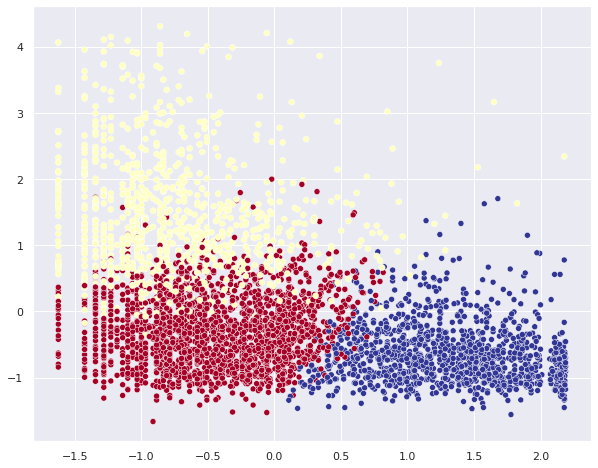

In [166]:
sns.scatterplot(np.array(df_final_scaled)[:, 0],np.array(df_final_scaled)[:, 2], c= kmeans.labels_, cmap='RdYlBu')

In [167]:
## so this is the final one, we can put these labels into the original dataframe

In [181]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4238 entries, 1 to 4338
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerID            4238 non-null   float64
 1   Frequency             4238 non-null   int64  
 2   Total_Trans_amt       4238 non-null   float64
 3   last_purchase         4238 non-null   int64  
 4   last_purchase_sqrt    4238 non-null   float64
 5   Frequency_sqrt        4238 non-null   float64
 6   Total_Trans_amt_sqrt  4238 non-null   float64
 7   ClusterNo             4138 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 298.0 KB


In [182]:
df_final['ClusterNo'] = kmeans.labels_

In [184]:
df_final.head()

,CustomerID,Frequency,Total_Trans_amt,last_purchase,last_purchase_sqrt,Frequency_sqrt,Total_Trans_amt_sqrt,ClusterNo
1,12347.0,182,4310.00,1,1.000000,13.490738,65.650590,1
2,12348.0,31,1797.24,74,8.602325,5.567764,42.393867,0
3,12349.0,73,1757.55,18,4.242641,8.544004,41.923144,0
4,12350.0,17,334.40,309,17.578396,4.123106,18.286607,2
5,12352.0,85,2506.04,35,5.916080,9.219544,50.060364,1


In [171]:
## in the main df

In [188]:
df_final[['CustomerID', 'ClusterNo']]

,CustomerID,ClusterNo
1,12347.0,1
2,12348.0,0
3,12349.0,0
4,12350.0,2
5,12352.0,1
...,...,...
4333,18278.0,0
4334,18280.0,2
4335,18281.0,2
4336,18282.0,0


In [189]:
df_nn_with_clusters = pd.merge(df_nn, df_final[['CustomerID', 'ClusterNo']], on = 'CustomerID')

In [190]:
df_nn_with_clusters.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Hour,Minute,Trans_amt,Difference,ClusterNo
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,8,26,15.30,373 days 04:24:00,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,20.34,373 days 04:24:00,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,8,26,22.00,373 days 04:24:00,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,20.34,373 days 04:24:00,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,20.34,373 days 04:24:00,1


# DONE